<img src = "images/Logo.png" width = 220, align = "left">

<h1 align=center><font size = 6>Linear transformation of numerical variables</font></h1>
<h2 align=center><font size = 5>Lab Exercise 3.4</font></h2>
<h3 align=center><font size = 4><b>Advanced Machine Learning<br></b><small>From Theory to Practice with NumPy and scikit-learn<br><i>Volume 1: Generalized Linear Models</i></font></h3>

## Introduction

In this lab execise we will explore different linear transformations as part of the data preprocessing techniques applied to numerical variables, i.e., variables that have numeric values. The following linear transformations will be applied:
- Centering
- Standardizing
- Min-Max scaling
- Max-Abs scaling
- Robust scaling

The following datasets will be used in the lab
- Blood pressure vs. age and weight
- Height vs. Weight dataset
- Star cluster dataset

### Table of contents
1. [Preparation](#Preparation)
2. [Centering the data](#DataCentering)
3. [Standardizing the data](#DataStandardization)
4. [Min-Max scaling](#MinMaxScaling)
5. [Max-Abs scaling](#MaxAbsScaling)
6. [Robust scaling](#RobustScaling)

## 1. Preparation <a name="Preparation"></a>

As a first step, we import the required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import eigh, inv, norm
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import seaborn as sns
import os
%matplotlib inline

### Blood pressure dataset

First we read the *BloodPressure2* dataset file into a pandas dataframe. This is a very tiny dataset, already used in CH3.Ex.1 lab exercise. Using this tiny dataset helps us in "seeing the numbers".

In [2]:
dataBP = pd.read_csv(os.path.join('data','BloodpressureAgeWeight.csv'))
dataBP

,Systolic blood pressure,Age in years,Weight in pounds
0,132,52,173
1,143,59,184
2,153,67,194
3,162,73,211
4,154,64,196
5,168,74,220
6,137,54,188
7,149,61,188
8,159,65,207
9,128,46,167


Then let's create the input matrix and the desing matrix.

In [3]:
X=np.array(dataBP[["Age in years","Weight in pounds"]])
N,D=X.shape
Xdot=np.insert(X,0,np.ones(N),axis=1)

Then check for coliniartity using the condition number.

In [4]:
eigval,eigvect=eigh(Xdot.T@Xdot)
print("Eigenvalues of the product matrix:")
print(eigval[:,np.newaxis])
print("Condition number =",np.sqrt(eigval.max()/eigval.min()))

Eigenvalues of the product matrix:
[[3.76601829e-02]
 [1.64291587e+02]
 [4.64856671e+05]]
Condition number = 3513.324963837358


The condition number is high, indicating that colliniarity might be present. Let's check the colliniarity issue using the variance inflation fators (VIF).

In [5]:
def vif(X,idx):
    from sklearn.linear_model import LinearRegression 
    linregr=LinearRegression()
    X_notidx=np.delete(X,idx,axis=1)
    X_idx=X[:,idx]
    linregr.fit(X_notidx,X_idx)
    R2=linregr.score(X_notidx,X_idx)
    return(1.0/(1.0-R2))

for idx in range(2):
    print(vif(X,idx))

9.52502151287206
9.525021512872101


And indeed, the VIF values are very close to 10 indicating high colliniarity issue. At centering the data We will see how the condition number and VIF is affected.

### Height-Weight dataset

Next, read the *HeightWeight* dataset into a new pandas dataframe and drop the Index column.

In [6]:
dataHW = pd.read_csv(os.path.join('data','HeightWeight.csv'))
dataHW=dataHW.drop(['Index'],axis=1)
dataHW.columns=['Height', 'Weight']

Then create the input and design matrix for this dataset, as well.

In [7]:
X1=np.array(dataHW[["Height"]])
X1dot=np.insert(X1,0,np.ones(X1.shape[0]),axis=1)

We can plot the distribution of the original *Height* and the centered *Height*.

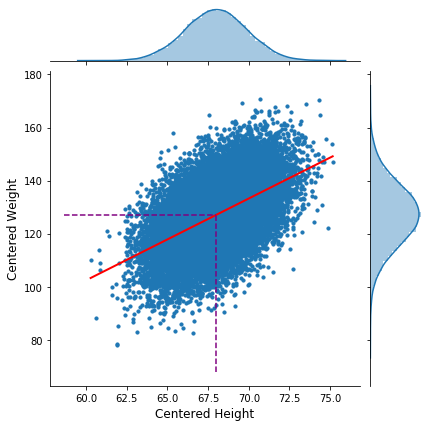

In [8]:
from sklearn.linear_model import LinearRegression
snsax=sns.jointplot(x="Height", y="Weight", marginal_kws=dict(bins=50,kde=True),s=10,data=dataHW);
linregr=LinearRegression().fit(np.array(dataHW['Height']).reshape(-1, 1),dataHW['Weight'])
snsax.ax_joint.plot([dataHW['Height'].min(),dataHW['Height'].max()],\
         [linregr.intercept_+linregr.coef_[0]*dataHW['Height'].min(),\
          linregr.intercept_+linregr.coef_[0]*dataHW['Height'].max()],'r-',lw=2)
snsax.ax_joint.plot([dataHW['Height'].mean(),dataHW['Height'].mean()],\
                   [snsax.ax_joint.get_ylim()[0],dataHW['Weight'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.plot([snsax.ax_joint.get_xlim()[0],dataHW['Height'].mean()],\
                   [dataHW['Weight'].mean(),dataHW['Weight'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.set_xlabel("Centered Height",fontsize=12)
snsax.ax_joint.set_ylabel("Centered Weight",fontsize=12)
plt.show()

We can show the summary of the OLS result using *statsmodels* library.

In [9]:
results = ols(formula = 'Weight ~ Height', data=dataHW).fit()
print(results.summary(title='OLS Results for original "HeightWeight" dataset'))
print("\nRMSE =",np.sqrt(results.mse_resid))

               OLS Results for original "HeightWeight" dataset                
Dep. Variable:                 Weight   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     8461.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:15:04   Log-Likelihood:                -93235.
No. Observations:               25000   AIC:                         1.865e+05
Df Residuals:                   24998   BIC:                         1.865e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -82.5757      2.280    -36.214      0.0

We may also get the standard errors of the estimated coefficients by taking the diagonal of the weight variance-covariance matrix.

In [10]:
np.sqrt(np.diag(results.mse_resid*inv(X1dot.T@X1dot)))[:,np.newaxis]

array([[2.28021584],
       [0.03352287]])

In the remaining part we will check how the different linear transformations applied to the input variables will affect the outcome of the linear regression.

## 2. Centering the data <a name="DataCentering"></a>

We shall start our investigation with centering the data.

### Properties of centering

Now, let's calculate the mean vector.

In [11]:
mu_=X.mean(axis=0,keepdims=True).T
mu_

array([[ 62.45454545],
       [195.        ]])

Then create the centered input matrix $\mathbf Xc=\mathbf X-\mu^\top$ and print out. Also print out the new mean values.

In [12]:
Xc=X-mu_.T
print(Xc)
print("--------- Mean --------------\n",Xc.mean(axis=0))

[[-10.45454545 -22.        ]
 [ -3.45454545 -11.        ]
 [  4.54545455  -1.        ]
 [ 10.54545455  16.        ]
 [  1.54545455   1.        ]
 [ 11.54545455  25.        ]
 [ -8.45454545  -7.        ]
 [ -1.45454545  -7.        ]
 [  2.54545455  12.        ]
 [-16.45454545 -28.        ]
 [  9.54545455  22.        ]]
--------- Mean --------------
 [1.29189588e-15 0.00000000e+00]


As we can see from above printout the centered data has zero mean.

Now, calculate the condition numer again, using the centered design matrix.

In [13]:
Xcdot=np.insert(Xc,0,np.ones(N),axis=1)
eigval,eigvect=eigh(Xcdot.T@Xcdot)
print("Eigenvalues of the product matrix:")
print(eigval[:,np.newaxis])
print("Condition number =",np.sqrt(eigval.max()/eigval.min()))

Eigenvalues of the product matrix:
[[  11.        ]
 [  69.55557898]
 [3759.17169375]]
Condition number = 18.486289006989363


As we can see, the condition number dropped significantly. Does that mean, that we get rid of the colliniarity issue by centering the data?

Let's check again this with VIF.

In [14]:
for idx in range(2):
    print(vif(Xc,idx))

9.525021512872081
9.52502151287209


As we can see, the VIF values are exactly the same, thus while centering the data resolves the conditioning problem of the OLS, does not solve the colliniearity issue. This seems reasonable, as with centering the data we do not do anything else, than we shift the entire scatter of observations, so their mean will be in the origin as we will seee below in the scatter plot.

**Note:** *Although, centering does not solve the colliniarity issue, if conditioning number is high we should still center the data. Remember from the book, that bad conditioning results in very different results, even if the input is changed slightly.*

Now, let's check that the centered data has the same hat matrix as the original data.

In [15]:
H=Xdot@inv(Xdot.T@Xdot)@Xdot.T
Hc=Xcdot@inv(Xcdot.T@Xcdot)@Xcdot.T
np.sum(np.abs(H-Hc))
H-Hc

array([[ 1.11577414e-14,  1.26010313e-14,  1.34614542e-14,
         1.55708779e-14,  1.41137102e-14,  1.66949787e-14,
         1.30312428e-14,  1.31006317e-14,  1.50157664e-14,
         1.06581410e-14,  1.62925229e-14],
       [ 8.40993941e-15,  9.46465128e-15,  1.04638520e-14,
         1.34614542e-14,  1.14214194e-14,  1.48978052e-14,
         1.11109039e-14,  1.04638520e-14,  1.36834988e-14,
         7.99360578e-15,  1.45335133e-14],
       [-1.41553436e-14, -1.49880108e-14, -1.61537450e-14,
        -1.35724765e-14, -1.35724765e-14, -1.07830411e-14,
        -9.85322934e-15, -1.50990331e-14, -9.93649607e-15,
        -1.31630817e-14, -1.02348685e-14],
       [ 4.44089210e-15,  5.53723734e-15,  5.99520433e-15,
         8.60422844e-15,  7.16093851e-15,  1.02140518e-14,
         7.45237205e-15,  5.95357097e-15,  9.60342916e-15,
         4.63518113e-15,  9.76996262e-15],
       [-1.08385523e-14, -1.12410081e-14, -1.19348975e-14,
        -1.22957200e-14, -1.15601972e-14, -1.19765309e-14,
  

And indeed, they are the same except, for rounding errors. We can check that the sample covariance matrix $\mathbf S$ does not change either.

In [16]:
S=1/(N-1)*(X-mu_.T).T@(X-mu_.T)
Sc=1/(N-1)*Xc.T@Xc
S-Sc

array([[0., 0.],
       [0., 0.]])

And yes, the covariance matrix is not affected by centering the data. The same is true for the Mahalanobis distances, they are not affected either when centering the data.

In [17]:
dM=np.sqrt(np.array([np.float((X[i][:,np.newaxis]-mu_).T@inv(S)@(X[i][:,np.newaxis]-mu_)) for i in range(N)]))\
[:,np.newaxis]
dMc=np.sqrt(np.array([np.float((Xc[i][:,np.newaxis]-Xc.mean(axis=0,keepdims=True).T).T@inv(Sc)@\
                               (Xc[i][:,np.newaxis]-Xc.mean(axis=0,keepdims=True).T)) for i in range(N)]))[:,np.newaxis]
dM-dMc

array([[ 0.00000000e+00],
       [ 4.44089210e-16],
       [ 2.22044605e-16],
       [ 4.44089210e-16],
       [ 3.88578059e-16],
       [-4.44089210e-16],
       [-4.44089210e-16],
       [ 3.33066907e-16],
       [-2.22044605e-16],
       [ 0.00000000e+00],
       [-2.22044605e-16]])

Now, let's check the correlation coefficient by creating the correlation matrix $\mathbf R$:

In [18]:
np.corrcoef(X,rowvar=False)

array([[1.        , 0.94605146],
       [0.94605146, 1.        ]])

Then normalize each column of the centered data using Eucledian norm. That is, we calculate first the Eucledian norm of each feature by taking the square root of sum of squared values for each column

In [19]:
norm2feature_=np.sqrt(np.sum(Xc**2,axis=0,keepdims=True)).T
norm2feature_

array([[28.82233982],
       [54.75399529]])

Then divide the input matrix with this vector of Eucledian norms to obtain normalized features (and not normalized observations!):

In [20]:
Xnf=Xc/norm2feature_.T
Xnf

array([[-0.36272369, -0.40179716],
       [-0.11985652, -0.20089858],
       [ 0.15770595, -0.01826351],
       [ 0.36587781,  0.29221612],
       [ 0.05362002,  0.01826351],
       [ 0.40057312,  0.45658769],
       [-0.29333307, -0.12784455],
       [-0.0504659 , -0.12784455],
       [ 0.08831533,  0.21916209],
       [-0.57089555, -0.51137821],
       [ 0.3311825 ,  0.40179716]])

If we take the Euclidian norm of each feature then it should be equal to one.

In [21]:
norm(Xnf,ord=2,axis=0)

array([1., 1.])

If we take the inner product of the two normalized feature vectors than it shouldb provide the cosine of the angle between the two feature vectors amd that should be exaclty the same as the pearson correlation coefficient between the input variables.

In [22]:
Xnf[:,0][:,np.newaxis].T@Xnf[:,1][:,np.newaxis]

array([[0.94605146]])

Because that value is close to 1 than the two feature vectors are almost colliniar.

### Visualization of centering

Next, read the *HeightWeight* dataset into a new pandas dataframe and drop the Index column.

In [23]:
dataHW = pd.read_csv(os.path.join('data','HeightWeight.csv'))
dataHW=dataHW.drop(['Index'],axis=1)
dataHW.columns=['Height', 'Weight']

We can plot the distribution of the original *Height* and the centered *Height*.

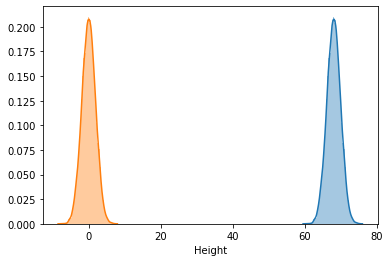

In [24]:
dataHWcenter=dataHW-dataHW.mean()
dataHWcenter['Weight']=dataHW['Weight']
sns.distplot(dataHW['Height'], kde=True, rug=False)
sns.distplot(dataHWcenter['Height'], kde=True, rug=False)
plt.show()

As can be seen from the above figure, the only difference between the two distribution is in their mean, the centered data has zero mean.

Next, create a joint disctribution (scatter plot of the weight vs. height) with marginal distributions for the original dataset. That should be the one we already seen in earlier lab exercise (for example, Ch2. Ex4).

Then make a comparision with the centered data.

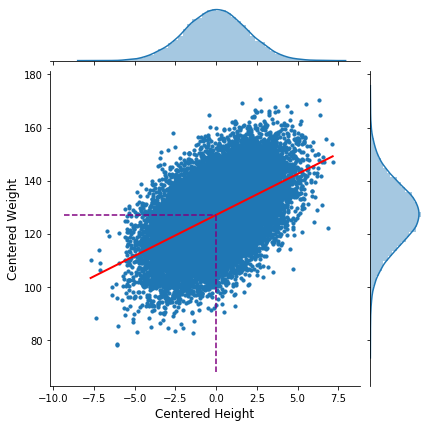

In [25]:
snsax=sns.jointplot(x="Height", y="Weight", marginal_kws=dict(bins=50,kde=True),s=10,data=dataHWcenter)
linregr=LinearRegression().fit(np.array(dataHWcenter['Height']).reshape(-1, 1),dataHWcenter['Weight'])
snsax.ax_joint.plot([dataHWcenter['Height'].min(),dataHWcenter['Height'].max()],\
         [linregr.intercept_+linregr.coef_[0]*dataHWcenter['Height'].min(),\
          linregr.intercept_+linregr.coef_[0]*dataHWcenter['Height'].max()],'r-',lw=2)
snsax.ax_joint.plot([dataHWcenter['Height'].mean(),dataHWcenter['Height'].mean()],\
                   [snsax.ax_joint.get_ylim()[0],dataHWcenter['Weight'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.plot([snsax.ax_joint.get_xlim()[0],dataHWcenter['Height'].mean()],\
                   [dataHWcenter['Weight'].mean(),dataHWcenter['Weight'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.set_xlabel("Centered Height",fontsize=12)
snsax.ax_joint.set_ylabel("Centered Weight",fontsize=12)
plt.show()

### Summary of OLS result for centered data

Finally, let's check the summary of the OLS results for the centered data.

In [26]:
resultsC = ols(formula = 'Weight ~ Height', data=dataHWcenter).fit()
print(resultsC.summary(title='OLS Results for centered "HeightWeight" dataset'))
print("\nRMSE =",np.sqrt(resultsC.mse_resid))

               OLS Results for centered "HeightWeight" dataset                
Dep. Variable:                 Weight   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     8461.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:15:06   Log-Likelihood:                -93235.
No. Observations:               25000   AIC:                         1.865e+05
Df Residuals:                   24998   BIC:                         1.865e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    127.0794      0.064   1993.451      0.0

In [27]:
X1c=np.array(dataHWcenter[["Height"]])
X1cdot=np.insert(X1c,0,np.ones(X1c.shape[0]),axis=1)
np.sqrt(np.diag(resultsC.mse_resid*inv(X1cdot.T@X1cdot)))[:,np.newaxis]

array([[0.06374846],
       [0.03352287]])

Although the estimated regression coefficients are very different looking at the graph is clear that we have the same estimated regression line, but on different scales.

**Note:** *Although centering the data does not have any effect on the estimated regression model, in case of high condition number it shall be applied to avoid big changes in the outcome when the input matrix is slightly modified.*

## 3. Standardizing the data <a name="DataStandardization"></a>

Another useful linear transformation is the standardization.

### Properties of standardization

Let's create the vector of standard devitaions:

In [28]:
sigma_=X.std(axis=0,keepdims=True,ddof=1).T
sigma_

array([[ 9.11442413],
       [17.31473361]])

And then create the standardized input matrix as $\mathbf {X_*}\equiv \frac{\mathbf{X}-\boldsymbol{\mu}^\top}{\boldsymbol\sigma^\top}$. Print out the standardized input matrix together with the new mean and standard deviation of each feature.

In [29]:
Xs=(X-mu_.T)/sigma_.T
print(Xs)
print("--------- Mean --------------\n",Xs.mean(axis=0))
print("----- Standard deviation ----\n",Xs.std(axis=0,ddof=1))

[[-1.14703302 -1.27059419]
 [-0.37901961 -0.6352971 ]
 [ 0.49871001 -0.05775428]
 [ 1.15700722  0.9240685 ]
 [ 0.1695614   0.05775428]
 [ 1.26672342  1.44385704]
 [-0.92760062 -0.40427997]
 [-0.1595872  -0.40427997]
 [ 0.27927761  0.69305138]
 [-1.80533023 -1.61711988]
 [ 1.04729102  1.27059419]]
--------- Mean --------------
 [1.41301112e-16 0.00000000e+00]
----- Standard deviation ----
 [1. 1.]


As can be seen, with standardized data we obtain a distribution with mean zero and unit variance.

We can check that the hat matrix is not altered with standardization

In [30]:
Xsdot=np.insert(Xs,0,np.ones(N),axis=1)
Hs=Xsdot@inv(Xsdot.T@Xsdot)@Xsdot.T
Hs-H

array([[-1.12132525e-14, -1.26287869e-14, -1.34336986e-14,
        -1.55153668e-14, -1.40998324e-14, -1.66117120e-14,
        -1.30589983e-14, -1.31006317e-14, -1.49914803e-14,
        -1.07136522e-14, -1.62231339e-14],
       [-8.54871729e-15, -9.52016244e-15, -1.04083409e-14,
        -1.33365541e-14, -1.14214194e-14, -1.47486190e-14,
        -1.11937369e-14, -1.04638520e-14, -1.36626821e-14,
        -8.10462808e-15, -1.44467771e-14],
       [ 1.43496326e-14,  1.50712776e-14,  1.60982339e-14,
         1.33504319e-14,  1.35447209e-14,  1.06165077e-14,
         1.00197628e-14,  1.51545443e-14,  9.88098492e-15,
         1.35308431e-14,  1.00496868e-14],
       [-3.80251386e-15, -5.28743715e-15, -6.21724894e-15,
        -9.32587341e-15, -7.27196081e-15, -1.09634524e-14,
        -7.02216063e-15, -5.82867088e-15, -9.86710713e-15,
        -3.58046925e-15, -1.04638520e-14],
       [ 1.08663079e-14,  1.12548859e-14,  1.19071419e-14,
         1.22679644e-14,  1.15601972e-14,  1.19210197e-14,
  

And indeed, they are equal except for rounding errors. 

With standardization, the covariance matrix $\mathbf S$ is equal to the correlation matrix $\mathbf R$ calculated earlier.

In [31]:
Ss=1/(N-1)*Xs.T@Xs
Ss

array([[1.        , 0.94605146],
       [0.94605146, 1.        ]])

We may check how the Mahalanobis distances are affected.

In [32]:
dMs=np.sqrt(np.array([np.float((Xs[i][:,np.newaxis]-Xs.mean(axis=0,keepdims=True).T).T@inv(Ss)@\
                               (Xs[i][:,np.newaxis]-Xs.mean(axis=0,keepdims=True).T)) for i in range(N)]))[:,np.newaxis]
dM-dMs

array([[-2.22044605e-16],
       [-1.11022302e-16],
       [-8.88178420e-16],
       [-2.22044605e-16],
       [ 2.22044605e-16],
       [-2.44249065e-15],
       [-1.11022302e-15],
       [-3.33066907e-16],
       [-1.55431223e-15],
       [-1.77635684e-15],
       [-1.55431223e-15]])

As we can see, the Mahalanobis distances are not affected. That should not be a surprise, because in the definition of the Mahalanobis distance the spread of the data is also counted. Just changing the scale of the spread, that will not affect the actual spread of the data, as we can see that below when visualizing the transformation.

We can use the *StandardScaler* of sklearn to obtain the same result. However, sklearn uses the biased version of the standard deviation (for large N this should not be a problem, only for small samples, like in our case, will be different).

In [33]:
from sklearn.preprocessing import StandardScaler
Std=StandardScaler()
Xstd=Std.fit_transform(X)

sigmab_=X.std(axis=0,keepdims=True).T
print("Biased standard deviation of the features:\n",sigmab_)
Xsb=(X-mu_.T)/sigmab_.T

Xstd-Xsb

Biased standard deviation of the features:
 [[ 8.69026243]
 [16.50895074]]


array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

You may obtain the mean and standard deviation of the features with *mean_* and *scale_* attribures.

In [34]:
print("Mean of the features:\n",Std.mean_)
print("\nStandard deviation of the features:\n",Std.scale_)

Mean of the features:
 [ 62.45454545 195.        ]

Standard deviation of the features:
 [ 8.69026243 16.50895074]


You may center the data only by setting the *with_std* parameter to False in the StandardScaler constructor.

In [35]:
Center=StandardScaler(with_std=False)
Xcenter=Center.fit_transform(X)
Xcenter-Xc

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

### Visualization of standardization

Now, let's visualize this data transformation.

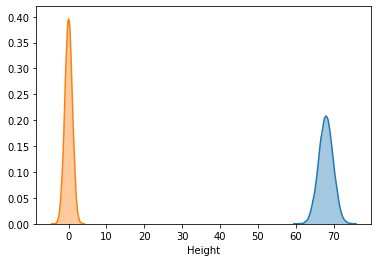

In [36]:
sns.distplot(dataHW['Height'], kde=True, rug=False)
dataHWstd=pd.DataFrame(Std.fit_transform(np.array(dataHW['Height']).reshape(-1,1)),columns=['Height'])
dataHWstd['Weight']=dataHW['Weight']
sns.distplot(dataHWstd['Height'], kde=True, rug=False)
plt.show()

As can be see from above, the standardized distribution is more sharp because it has unit variance.

let's check the joint distribution with marginal distribution of the standardized data. Let's plot the estimated regression line, as well.

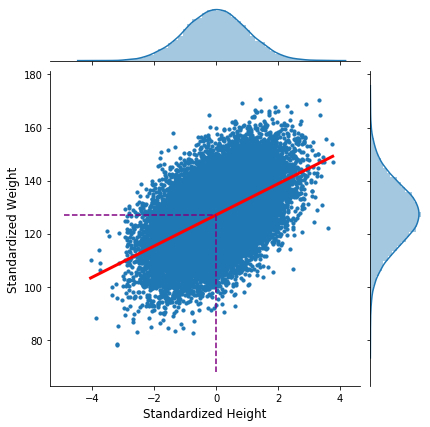

In [37]:
snsax=sns.jointplot(x="Height", y="Weight", marginal_kws=dict(bins=50,kde=True),s=10,data=dataHWstd)
linregr=LinearRegression().fit(np.array(dataHWstd['Height']).reshape(-1, 1),dataHWstd['Weight'])
snsax.ax_joint.plot([dataHWstd['Height'].min(),dataHWstd['Height'].max()],\
         [linregr.intercept_+linregr.coef_[0]*dataHWstd['Height'].min(),\
          linregr.intercept_+linregr.coef_[0]*dataHWstd['Height'].max()],'r-',lw=3)
snsax.ax_joint.plot([dataHWstd['Height'].mean(),dataHWstd['Height'].mean()],\
                   [snsax.ax_joint.get_ylim()[0],dataHWstd['Weight'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.plot([snsax.ax_joint.get_xlim()[0],dataHWstd['Height'].mean()],\
                   [dataHWstd['Weight'].mean(),dataHWstd['Weight'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.set_xlabel("Standardized Height",fontsize=12)
snsax.ax_joint.set_ylabel("Standardized Weight",fontsize=12)
plt.show()

### Summary of OLS result for standardized data

Finally, let's check the summary of the OLS results for the standardized data.

In [38]:
resultsStd = ols(formula = 'Weight ~ Height', data=dataHWstd).fit()
print(resultsStd.summary(title='OLS Results for standerdized "HeightWeight" dataset'))
print("RMSE =",np.sqrt(resultsStd.mse_resid))

             OLS Results for standerdized "HeightWeight" dataset              
Dep. Variable:                 Weight   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     8461.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:15:08   Log-Likelihood:                -93235.
No. Observations:               25000   AIC:                         1.865e+05
Df Residuals:                   24998   BIC:                         1.865e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    127.0794      0.064   1993.451      0.0

We may also get the standard errors of the estimated coefficients by taking the diagonal of the weight variance-covariance matrix.

In [39]:
X1std=np.array(dataHWcenter[["Height"]])
X1stddot=np.insert(X1std,0,np.ones(X1std.shape[0]),axis=1)
np.sqrt(np.diag(resultsStd.mse_resid*inv(X1stddot.T@X1stddot)))[:,np.newaxis]

array([[0.06374846],
       [0.03352287]])

Although the estimated regression coefficients are very different, from the plot it is clear that we have the same distribution on a different scale, and the regression line is the same relative the the scatter of data points.

**Note:** *While standardization does not have any effect on linear regression there are machine learning algorithms that perform better when the data is standardized.*

## 4. Min-Max scaling <a name="MinMaxScaling"></a>

With min-max scaling each feature is transformed such thay their values will be in the range of $[0,1]$.

### Properties of min-max scaling

The input matrix can be min-max scaled in the following vectorized form: $\mathbf{X}_s=\frac{\mathbf{X}-\mathbf x_{\min}^\top}{(\mathbf x_{\max}-\mathbf x_{\min})^\top}$.

Let's create the min-max scaled input matrix and print out. We should also print out the minimum and maximum values of each feature.

In [40]:
xmin_=X.min(axis=0,keepdims=True).T
xmax_=X.max(axis=0,keepdims=True).T
Xmm=(X-xmin_.T)/(xmax_-xmin_).T
print(Xmm)
print("--------- Min --------------\n",Xmm.min(axis=0))
print("--------- Max --------------\n",Xmm.max(axis=0))

[[0.21428571 0.11320755]
 [0.46428571 0.32075472]
 [0.75       0.50943396]
 [0.96428571 0.83018868]
 [0.64285714 0.54716981]
 [1.         1.        ]
 [0.28571429 0.39622642]
 [0.53571429 0.39622642]
 [0.67857143 0.75471698]
 [0.         0.        ]
 [0.92857143 0.94339623]]
--------- Min --------------
 [0. 0.]
--------- Max --------------
 [1. 1.]


And indeed, the min-max scaled input matrix has only values within the $[0,1]$ range.

Let's check the hat matrix.

In [41]:
Xmmdot=np.insert(Xmm,0,np.ones(N),axis=1)
Hmm=Xmmdot@inv(Xmmdot.T@Xmmdot)@Xmmdot.T
Hmm-H

array([[-1.18238752e-14, -1.32949207e-14, -1.44328993e-14,
        -1.60149671e-14, -1.45022883e-14, -1.64313008e-14,
        -1.26842981e-14, -1.37945211e-14, -1.46584134e-14,
        -1.09356968e-14, -1.60566005e-14],
       [-8.71525074e-15, -9.71445147e-15, -1.08801856e-14,
        -1.32394096e-14, -1.12965193e-14, -1.40165657e-14,
        -1.04196166e-14, -1.06303855e-14, -1.28161370e-14,
        -8.02136135e-15, -1.36869682e-14],
       [ 1.40720768e-14,  1.48214774e-14,  1.56541446e-14,
         1.39332990e-14,  1.39610545e-14,  1.20181642e-14,
         1.10189635e-14,  1.49047441e-14,  1.12965193e-14,
         1.34753320e-14,  1.15450184e-14],
       [-4.32466563e-15, -5.68989300e-15, -6.63358257e-15,
        -9.43689571e-15, -7.46624984e-15, -1.08246745e-14,
        -7.21644966e-15, -6.24500451e-15, -9.81853487e-15,
        -4.13558077e-15, -1.02973186e-14],
       [ 1.08246745e-14,  1.12687637e-14,  1.19348975e-14,
         1.25732758e-14,  1.17544863e-14,  1.24483757e-14,
  

The Hat matrix is not changed (nor the leverages), thus the prediction is the same after the min-max scaling.

In [42]:
Smm=1/(N-1)*Xmm.T@Xmm
Smm

array([[0.48584184, 0.4421159 ],
       [0.4421159 , 0.41374155]])

The scatter matrix is changed. Let's see the Mahalanobis distances.

In [43]:
dMmm=np.sqrt(np.array([np.float((Xmm[i][:,np.newaxis]-Xmm.mean(axis=0,keepdims=True).T).T@inv(Smm)@\
                                (Xmm[i][:,np.newaxis]-Xmm.mean(axis=0,keepdims=True).T)) for i in range(N)]))[:,np.newaxis]
dM-dMmm

array([[3.96506221e-01],
       [2.52806954e-02],
       [1.32259853e-01],
       [6.09211703e-01],
       [5.53607699e-02],
       [3.96555707e-01],
       [3.26278919e-01],
       [7.02761210e-04],
       [1.54592015e-03],
       [9.81682900e-01],
       [2.60812219e-01]])

The Mahalanobis distances are also changed.

We can get the same result with sklearn MinMaxScaler.

In [44]:
from sklearn.preprocessing import MinMaxScaler
MinMax=MinMaxScaler()
Xmmscale=MinMax.fit_transform(X)

Xmmscale-Xmm

array([[-8.32667268e-17, -2.77555756e-17],
       [ 1.11022302e-16, -2.77555756e-16],
       [ 0.00000000e+00,  1.11022302e-16],
       [ 1.11022302e-16, -2.22044605e-16],
       [-1.11022302e-16,  1.11022302e-16],
       [ 0.00000000e+00,  0.00000000e+00],
       [-1.11022302e-16, -3.33066907e-16],
       [-1.11022302e-16, -3.33066907e-16],
       [-2.22044605e-16, -2.22044605e-16],
       [ 0.00000000e+00,  0.00000000e+00],
       [-2.22044605e-16,  2.22044605e-16]])

### Visualization of min-max scaling

Now, let's visualize this data transformation.

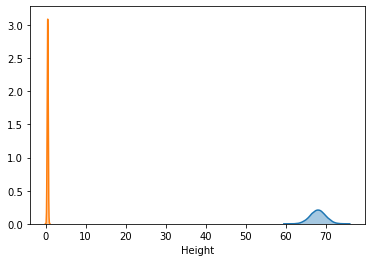

In [45]:
sns.distplot(dataHW['Height'], kde=True, rug=False)
dataHWmm=pd.DataFrame(MinMax.fit_transform(np.array(dataHW['Height']).reshape(-1,1)),columns=['Height'])
dataHWmm['Weight']=dataHW['Weight']
sns.distplot(dataHWmm['Height'], kde=True, rug=False)
plt.show()

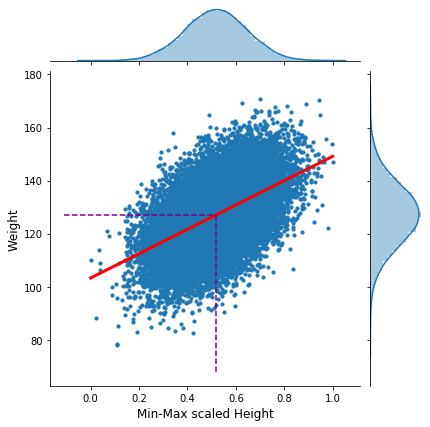

Estimated coefficients of the simple linear regression:
 103.29116016297942 45.864985378559666
R-squared value:
 0.2528666917428809


In [46]:
snsax=sns.jointplot(x="Height", y="Weight", marginal_kws=dict(bins=50,kde=True),s=10,data=dataHWmm)
linregr=LinearRegression().fit(np.array(dataHWmm['Height']).reshape(-1, 1),dataHWmm['Weight'])
snsax.ax_joint.plot([dataHWmm['Height'].min(),dataHWmm['Height'].max()],\
         [linregr.intercept_+linregr.coef_[0]*dataHWmm['Height'].min(),\
          linregr.intercept_+linregr.coef_[0]*dataHWmm['Height'].max()],'r-',lw=3)
snsax.ax_joint.plot([dataHWmm['Height'].mean(),dataHWmm['Height'].mean()],\
                   [snsax.ax_joint.get_ylim()[0],dataHWmm['Weight'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.plot([snsax.ax_joint.get_xlim()[0],dataHWmm['Height'].mean()],\
                   [dataHWmm['Weight'].mean(),dataHWmm['Weight'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.set_xlabel("Min-Max scaled Height",fontsize=12)
snsax.ax_joint.set_ylabel("Weight",fontsize=12)
plt.show()

print("Estimated coefficients of the simple linear regression:\n",linregr.intercept_,linregr.coef_[0])
print("R-squared value:\n",linregr.score(np.array(dataHWmm['Height']).reshape(-1, 1),dataHWmm['Weight']))

### Summary of OLS result for min-max scaling

Finally, let's check the summary of the OLS results for the min-max scaled data.

In [47]:
resultsMM = ols(formula = 'Weight ~ Height', data=dataHWmm).fit()
print(resultsMM.summary(title='OLS Results for min-max scaled "HeightWeight" dataset'))
print("\nRMSE =",np.sqrt(resultsMM.mse_resid))

            OLS Results for min-max scaled "HeightWeight" dataset             
Dep. Variable:                 Weight   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     8461.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:15:10   Log-Likelihood:                -93235.
No. Observations:               25000   AIC:                         1.865e+05
Df Residuals:                   24998   BIC:                         1.865e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    103.2912      0.266    387.785      0.0

We may also get the standard errors of the estimated coefficients by taking the diagonal of the weight variance-covariance matrix.

In [48]:
X1mm=np.array(dataHWmm[["Height"]])
X1mmdot=np.insert(X1mm,0,np.ones(X1mm.shape[0]),axis=1)
np.sqrt(np.diag(resultsMM.mse_resid*inv(X1mmdot.T@X1mmdot)))[:,np.newaxis]

array([[0.26636167],
       [0.49863397]])

## 5. Max-Abs scaling <a name="MaxAbsScaling"></a>

With max scaling each feature is transformed such thay their absolute values will be less or equal to 1. If the original feature has also negative values in amplitude close to the max-abs value then the feature will be translated into the range of $[-1,+1$.

### Properties of max-abs scaling

The input matrix can be min-max scaled in the following vectorized form: $\mathbf X_r=\frac{\mathbf{X}}{|\left \{ \mathbf x_j \right \}_{\max}|^\top}$.

Let's create the max-abs scaled input matrix and print out. We should also print out the minimum and maximum values of each feature.

In [49]:
xmin_=X.min(axis=0,keepdims=True).T
xmax_=X.max(axis=0,keepdims=True).T
Xma=(X)/(np.abs(xmax_)).T
print(Xmm)
print("--------- Min --------------\n",Xmm.min(axis=0))
print("--------- Max --------------\n",Xmm.max(axis=0))

[[0.21428571 0.11320755]
 [0.46428571 0.32075472]
 [0.75       0.50943396]
 [0.96428571 0.83018868]
 [0.64285714 0.54716981]
 [1.         1.        ]
 [0.28571429 0.39622642]
 [0.53571429 0.39622642]
 [0.67857143 0.75471698]
 [0.         0.        ]
 [0.92857143 0.94339623]]
--------- Min --------------
 [0. 0.]
--------- Max --------------
 [1. 1.]


And indeed, the min-max scaled input matrix has only values within the $[0,1]$ range.

Let's check the hat matrix.

In [50]:
Xmadot=np.insert(Xma,0,np.ones(N),axis=1)
Hma=Xmmdot@inv(Xmadot.T@Xmadot)@Xmadot.T
Hma-H

array([[ 1.30296825e+00,  1.41589844e+00,  2.22417546e+00,
         3.21065031e-01,  4.02273722e-01, -1.62497571e+00,
        -1.79669697e+00,  1.22175956e+00, -2.07204454e+00,
         3.00552346e-01, -1.69497559e+00],
       [ 1.01550199e+00,  1.15507152e+00,  1.87947955e+00,
         3.35793923e-01,  3.44647384e-01, -1.27620090e+00,
        -1.54943765e+00,  1.00664853e+00, -1.70671410e+00,
         1.42670972e-01, -1.34746124e+00],
       [ 7.69624897e-01,  9.80326386e-01,  1.72157837e+00,
         4.28631598e-01,  3.24546444e-01, -9.87013441e-01,
        -1.47780652e+00,  8.73710052e-01, -1.48033770e+00,
        -7.82434187e-02, -1.07501666e+00],
       [ 2.79849935e-01,  3.93584535e-01,  7.31126920e-01,
         2.17464877e-01,  1.40421339e-01, -3.65905055e-01,
        -6.44736614e-01,  3.56893474e-01, -6.04384136e-01,
        -9.43835103e-02, -4.09931765e-01],
       [ 6.77001329e-01,  7.70047682e-01,  1.25298637e+00,
         2.23862615e-01,  2.29764922e-01, -8.50800597e-01,
  

The Hat matrix is not changed (nor the leverages), thus the prediction is the same after the min-max scaling.

In [51]:
Sma=1/(N-1)*Xma.T@Xma
Sma

array([[0.79870343, 0.8320516 ],
       [0.8320516 , 0.87039876]])

The scatter matrix is changed. Let's see the Mahalanobis distances.

In [52]:
dMma=np.sqrt(np.array([np.float((Xma[i][:,np.newaxis]-Xma.mean(axis=0,keepdims=True).T).T@inv(Sma)@\
                                (Xma[i][:,np.newaxis]-Xma.mean(axis=0,keepdims=True).T)) for i in range(N)]))[:,np.newaxis]
dM-dMma

array([[4.80588983e-01],
       [8.77387001e-01],
       [5.65483028e-01],
       [4.04806309e-05],
       [7.18148950e-02],
       [6.43267804e-01],
       [2.72648250e-01],
       [6.07752868e-01],
       [1.03872345e+00],
       [7.13326551e-02],
       [7.67034284e-01]])

The Mahalanobis distances are also changed.

We can get the same result with sklearn MinMaxScaler.

In [53]:
from sklearn.preprocessing import MaxAbsScaler
MaxAbs=MaxAbsScaler()
Xmascale=MaxAbs.fit_transform(X)

Xmascale-Xma

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

### Visualization of max-abs scaling

Now, let's visualize this data transformation.

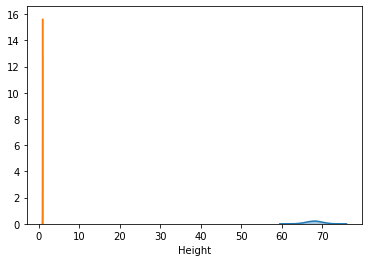

In [54]:
sns.distplot(dataHW['Height'], kde=True, rug=False)
dataHWma=pd.DataFrame(MaxAbs.fit_transform(np.array(dataHW['Height']).reshape(-1,1)),columns=['Height'])
dataHWma['Weight']=dataHW['Weight']
sns.distplot(dataHWma['Height'], kde=True, rug=False)
plt.show()

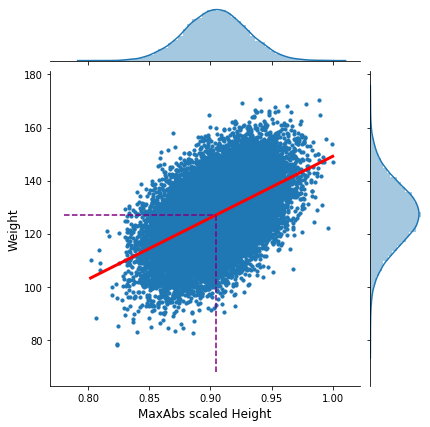

In [55]:
snsax=sns.jointplot(x="Height", y="Weight", marginal_kws=dict(bins=50,kde=True),s=10,data=dataHWma)
linregr=LinearRegression().fit(np.array(dataHWma['Height']).reshape(-1, 1),dataHWma['Weight'])
snsax.ax_joint.plot([dataHWma['Height'].min(),dataHWma['Height'].max()],\
         [linregr.intercept_+linregr.coef_[0]*dataHWma['Height'].min(),\
          linregr.intercept_+linregr.coef_[0]*dataHWma['Height'].max()],'r-',lw=3)
snsax.ax_joint.plot([dataHWma['Height'].mean(),dataHWma['Height'].mean()],\
                   [snsax.ax_joint.get_ylim()[0],dataHWma['Weight'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.plot([snsax.ax_joint.get_xlim()[0],dataHWma['Height'].mean()],\
                   [dataHWma['Weight'].mean(),dataHWma['Weight'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.set_xlabel("MaxAbs scaled Height",fontsize=12)
snsax.ax_joint.set_ylabel("Weight",fontsize=12)
plt.show()

### Summary of OLS result for max-abs scaling

Finally, let's check the summary of the OLS results for the max-abs scaled data.

In [56]:
resultsMA = ols(formula = 'Weight ~ Height', data=dataHWma).fit()
print(resultsMA.summary(title='OLS Results for max-abs scaled "HeightWeight" dataset'))
print("\nRMSE =",np.sqrt(resultsMA.mse_resid))

            OLS Results for max-abs scaled "HeightWeight" dataset             
Dep. Variable:                 Weight   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     8461.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:15:12   Log-Likelihood:                -93235.
No. Observations:               25000   AIC:                         1.865e+05
Df Residuals:                   24998   BIC:                         1.865e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -82.5757      2.280    -36.214      0.0

We may also get the standard errors of the estimated coefficients by taking the diagonal of the weight variance-covariance matrix.

In [57]:
X1ma=np.array(dataHWma[["Height"]])
X1madot=np.insert(X1ma,0,np.ones(X1ma.shape[0]),axis=1)
np.sqrt(np.diag(resultsMA.mse_resid*inv(X1madot.T@X1madot)))[:,np.newaxis]

array([[2.28021584],
       [2.51933781]])

## 6. Robust scaling <a name="RobustScaling"></a>

With robust scaling each feature is transformed such thay their values will be in the range of $[0,1]$.

### Properties of robust scaling

The input matrix can be min-max scaled in the following vectorized form: $\mathbf X_r=\frac{\mathbf{X}-\mathbf{\tilde x}^\top}{\mathbf s_\text{IQR}^\top}$.

Let's create the robust scaled input matrix and print out. We should also print out the minimum and maximum values of each feature.

In [58]:
from scipy.stats import iqr
xmed_=np.median(X,axis=0,keepdims=True).T
xiqr_=iqr(X,axis=0,keepdims=True).T
Xr=(X-xmed_.T)/xiqr_.T
print(Xr)
print("--------- Median ----------\n",np.median(Xr,axis=0))
print("---------- IQR ------------\n",iqr(Xr,axis=0))

[[-0.92307692 -0.91304348]
 [-0.38461538 -0.43478261]
 [ 0.23076923  0.        ]
 [ 0.69230769  0.73913043]
 [ 0.          0.08695652]
 [ 0.76923077  1.13043478]
 [-0.76923077 -0.26086957]
 [-0.23076923 -0.26086957]
 [ 0.07692308  0.56521739]
 [-1.38461538 -1.17391304]
 [ 0.61538462  1.        ]]
--------- Median ----------
 [0. 0.]
---------- IQR ------------
 [1. 1.]


And indeed, the min-max scaled input matrix has only values within the $[0,1]$ range.

Let's check the hat matrix.

In [59]:
Xrdot=np.insert(Xr,0,np.ones(N),axis=1)
Hr=Xrdot@inv(Xrdot.T@Xrdot)@Xrdot.T
Hr-H

array([[-1.12132525e-14, -1.25732758e-14, -1.32949207e-14,
        -1.54494473e-14, -1.40720768e-14, -1.66117120e-14,
        -1.31977762e-14, -1.30728761e-14, -1.50816859e-14,
        -1.07691633e-14, -1.62925229e-14],
       [-8.40993941e-15, -9.32587341e-15, -1.00475184e-14,
        -1.32394096e-14, -1.13381526e-14, -1.49082136e-14,
        -1.15229007e-14, -1.02973186e-14, -1.39402379e-14,
        -8.13238366e-15, -1.46757606e-14],
       [ 1.43218770e-14,  1.53765889e-14,  1.70974346e-14,
         1.40443213e-14,  1.37667655e-14,  1.06338549e-14,
         8.90953977e-15,  1.54876112e-14,  9.29811783e-15,
         1.29549149e-14,  9.87404603e-15],
       [-4.37150316e-15, -5.34294831e-15, -5.55111512e-15,
        -8.43769499e-15, -7.04991621e-15, -1.02140518e-14,
        -7.85482790e-15, -5.75928194e-15, -9.88792381e-15,
        -4.71844785e-15, -9.90874049e-15],
       [ 1.08524301e-14,  1.13103971e-14,  1.21014310e-14,
         1.23789867e-14,  1.16018306e-14,  1.19626531e-14,
  

The Hat matrix is not changed (nor the leverages), thus the prediction is the same after the min-max scaling.

In [60]:
Sr=1/(N-1)*Xr.T@Xr
Sr

array([[0.50710059, 0.49364548],
       [0.49364548, 0.56880907]])

The scatter matrix is changed. Let's see the Mahalanobis distances.

In [61]:
dMr=np.sqrt(np.array([np.float((Xr[i][:,np.newaxis]-Xr.mean(axis=0,keepdims=True).T).T@inv(Sr)@\
                               (Xr[i][:,np.newaxis]-Xr.mean(axis=0,keepdims=True).T)) for i in range(N)]))[:,np.newaxis]
dM-dMr

array([[0.01025478],
       [0.10641268],
       [0.32656142],
       [0.08880088],
       [0.06437864],
       [0.02139089],
       [0.29555013],
       [0.12156383],
       [0.20465971],
       [0.04882141],
       [0.04389603]])

The Mahalanobis distances are also changed.

We can get the same result with sklearn MinMaxScaler.

In [62]:
from sklearn.preprocessing import RobustScaler
Robust=RobustScaler()
Xrscale=Robust.fit_transform(X)

Xrscale-Xr

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

### Visualization of robust scaling

Now, let's visualize this data transformation.

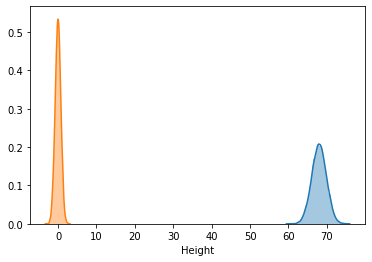

In [63]:
sns.distplot(dataHW['Height'], kde=True, rug=False)
dataHWr=pd.DataFrame(Robust.fit_transform(np.array(dataHW['Height']).reshape(-1,1)),columns=['Height'])
dataHWr['Weight']=dataHW['Weight']
sns.distplot(dataHWr['Height'], kde=True, rug=False)
plt.show()

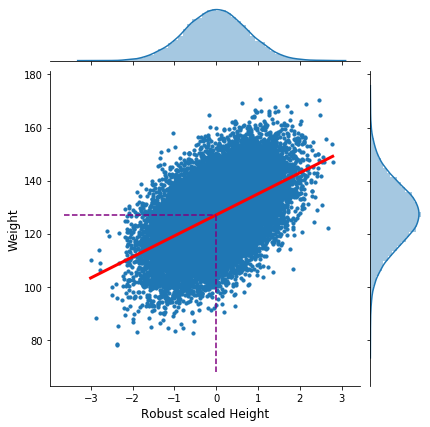

In [64]:
snsax=sns.jointplot(x="Height", y="Weight", marginal_kws=dict(bins=50,kde=True),s=10,data=dataHWr)
linregr=LinearRegression().fit(np.array(dataHWr['Height']).reshape(-1, 1),dataHWr['Weight'])
snsax.ax_joint.plot([dataHWr['Height'].min(),dataHWr['Height'].max()],\
         [linregr.intercept_+linregr.coef_[0]*dataHWr['Height'].min(),\
          linregr.intercept_+linregr.coef_[0]*dataHWr['Height'].max()],'r-',lw=3)
snsax.ax_joint.plot([dataHWr['Height'].mean(),dataHWr['Height'].mean()],\
                   [snsax.ax_joint.get_ylim()[0],dataHWr['Weight'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.plot([snsax.ax_joint.get_xlim()[0],dataHWr['Height'].mean()],\
                   [dataHWr['Weight'].mean(),dataHWr['Weight'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.set_xlabel("Robust scaled Height",fontsize=12)
snsax.ax_joint.set_ylabel("Weight",fontsize=12)
plt.show()

### Summary of OLS result for robust scaled data

Finally, let's check the summary of the OLS results for the max-abs scaled data.

In [65]:
resultsR = ols(formula = 'Weight ~ Height', data=dataHWr).fit()
print(resultsR.summary(title='OLS Results for robust scaled "HeightWeight" dataset'))
print("\nRMSE =",np.sqrt(resultsR.mse_resid))

             OLS Results for robust scaled "HeightWeight" dataset             
Dep. Variable:                 Weight   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     8461.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:15:15   Log-Likelihood:                -93235.
No. Observations:               25000   AIC:                         1.865e+05
Df Residuals:                   24998   BIC:                         1.865e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    127.0874      0.064   1993.574      0.0

We may also get the standard errors of the estimated coefficients by taking the diagonal of the weight variance-covariance matrix.

In [66]:
X1r=np.array(dataHWr[["Height"]])
X1rdot=np.insert(X1r,0,np.ones(X1r.shape[0]),axis=1)
np.sqrt(np.diag(resultsR.mse_resid*inv(X1rdot.T@X1rdot)))[:,np.newaxis]

array([[0.06374852],
       [0.08610551]])

### Robust scaling for Star cluster dataset

Because the HeightWeight dataset does not have any outlier we may argue that the Robust scaler could not be effecteve. So let's see in action with a small dataset which excibits both outlier masking and swamping effect.

In [67]:
dataStar = pd.read_csv(os.path.join('data','StarClusterCYGOB1.csv'))
dataStar=dataStar.rename(columns={"Log surface termperature of the star": "LogSurfTemp",\
                                  "Log light intensity of the star":"LogLightIntensity"})

As a recap make the scatter plot together with the marginal distributions.

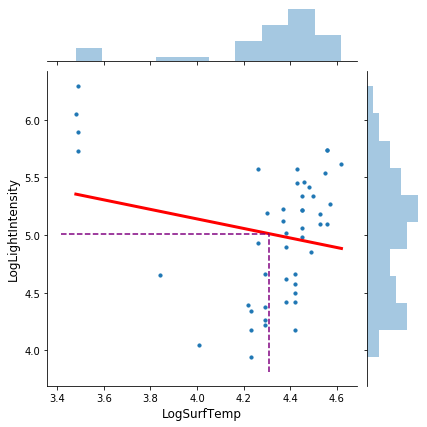

In [68]:
snsax=sns.jointplot(x="LogSurfTemp", y="LogLightIntensity", marginal_kws=dict(bins=10,kde=False),s=10,data=dataStar)
linregr=LinearRegression().fit(np.array(dataStar['LogSurfTemp']).reshape(-1, 1),dataStar['LogLightIntensity'])
snsax.ax_joint.plot([dataStar['LogSurfTemp'].min(),dataStar['LogSurfTemp'].max()],\
         [linregr.intercept_+linregr.coef_[0]*dataStar['LogSurfTemp'].min(),\
          linregr.intercept_+linregr.coef_[0]*dataStar['LogSurfTemp'].max()],'r-',lw=3)
snsax.ax_joint.plot([dataStar['LogSurfTemp'].mean(),dataStar['LogSurfTemp'].mean()],\
                   [snsax.ax_joint.get_ylim()[0],dataStar['LogLightIntensity'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.plot([snsax.ax_joint.get_xlim()[0],dataStar['LogSurfTemp'].mean()],\
                   [dataStar['LogLightIntensity'].mean(),dataStar['LogLightIntensity'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.set_xlabel("LogSurfTemp",fontsize=12)
snsax.ax_joint.set_ylabel("LogLightIntensity",fontsize=12)
plt.show()

Check the summary of the OLS results.

In [69]:
resultStar = ols(formula = 'LogLightIntensity ~ LogSurfTemp', data=dataStar).fit()
print(resultStar.summary(title='OLS Results for original "Star cluster" dataset'))
print("\nRMSE =",np.sqrt(resultStar.mse_resid))

               OLS Results for original "Star cluster" dataset                
Dep. Variable:      LogLightIntensity   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.085
Date:                Tue, 21 Apr 2020   Prob (F-statistic):              0.156
Time:                        23:15:16   Log-Likelihood:                -38.804
No. Observations:                  47   AIC:                             81.61
Df Residuals:                      45   BIC:                             85.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.7935      1.237      5.494      

Let's create the squared studentized residuals versus leverages plot together with the contour plot of Cook's distances. Based on the knowledge already acquired in Ex. 3.3 let's create a function, which can be reused in later lab exercises.

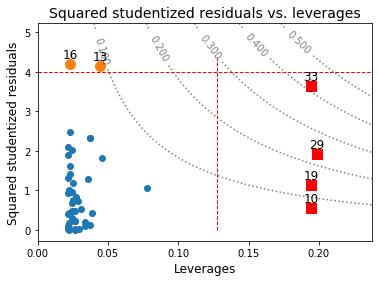

In [70]:
def SquaredStudResidLeveragePlot(OLSresults,CookLevels=None,textdx=0,textdy=0,xyscale=1.2):
    N=int(OLSresults.nobs)
    D=int(OLSresults.df_model)
    h_=OLSresults.get_influence().hat_matrix_diag[:,np.newaxis]
    idx_X=np.nonzero(h_>=3*h_.mean())[0]
    rstud_=OLSresults.get_influence().resid_studentized_external
    idx_R=np.nonzero(np.abs(rstud_)>2.0)[0]
    plt.scatter(h_,rstud_**2)
    plt.scatter(h_[idx_R],rstud_[idx_R]**2,s=100)
    for i in idx_R:
        plt.annotate(i, (float(h_[i]),float(rstud_[i]**2)),(float(h_[i])+textdx,float(rstud_[i]**2)+textdy),fontsize=12)
    plt.scatter(h_[idx_X],rstud_[idx_X]**2,s=100,c='r',marker='s')
    for i in idx_X:
        plt.annotate(i, (float(h_[i]),float(rstud_[i]**2)),(float(h_[i])+textdx,float(rstud_[i]**2)+textdy),fontsize=12)
    plt.plot([3*h_.mean(),3*h_.mean()],[0,xyscale*(rstud_.max())**2],'r--',lw=1)
    plt.plot([0,xyscale*h_.max()],[4,4],'r--',lw=1)
    plt.xlabel('Leverages',fontsize=12)
    plt.ylabel('Squared studentized residuals',fontsize=12)
    plt.title("Squared studentized residuals vs. leverages",fontsize=14)

    if CookLevels!=None:
        # Adding contour plot of the Cook's distances
        x = np.linspace(0, xyscale*h_.max(), 100)
        y = np.linspace(0, (xyscale*rstud_.max())**2, 100)
        X, Y = np.meshgrid(x, y)
        Z = (N-D-1)/(Y+N-D-2)*Y/(D+1)*X/(1-X)
        CS=plt.contour(X, Y, Z, colors='black',levels=CookLevels,linestyles="dotted",alpha=0.5)
        plt.clabel(CS)
        plt.show()
               
# Calling the r_stud**2 x leverage plot function with conour of Cook's distances
SquaredStudResidLeveragePlot(resultStar,CookLevels=[0.1,0.2,0.3,0.4,0.5],textdx=-0.005,textdy=0.15)

Now create the robust scaled version of the scatter plot.

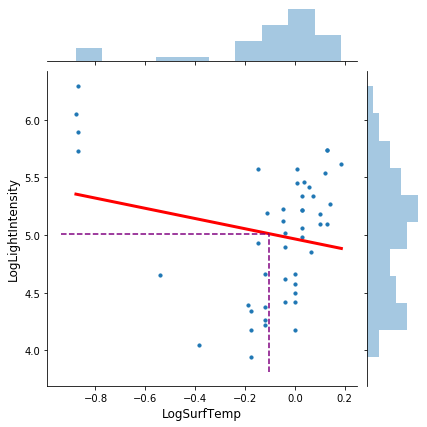

In [71]:
Robust.set_params(quantile_range=(5.0, 95.0))
dataStarR=pd.DataFrame(Robust.fit_transform(np.array(dataStar['LogSurfTemp']).reshape(-1,1)),columns=['LogSurfTemp'])
dataStarR['LogLightIntensity']=dataStar['LogLightIntensity']

snsax=sns.jointplot(x="LogSurfTemp", y="LogLightIntensity", marginal_kws=dict(bins=10,kde=False),s=10,data=dataStarR)
linregr=LinearRegression().fit(np.array(dataStarR['LogSurfTemp']).reshape(-1, 1),dataStarR['LogLightIntensity'])
snsax.ax_joint.plot([dataStarR['LogSurfTemp'].min(),dataStarR['LogSurfTemp'].max()],\
         [linregr.intercept_+linregr.coef_[0]*dataStarR['LogSurfTemp'].min(),\
          linregr.intercept_+linregr.coef_[0]*dataStarR['LogSurfTemp'].max()],'r-',lw=3)
snsax.ax_joint.plot([dataStarR['LogSurfTemp'].mean(),dataStarR['LogSurfTemp'].mean()],\
                   [snsax.ax_joint.get_ylim()[0],dataStarR['LogLightIntensity'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.plot([snsax.ax_joint.get_xlim()[0],dataStarR['LogSurfTemp'].mean()],\
                   [dataStarR['LogLightIntensity'].mean(),dataStarR['LogLightIntensity'].mean()],c='purple',linestyle='dashed')
snsax.ax_joint.set_xlabel("LogSurfTemp",fontsize=12)
snsax.ax_joint.set_ylabel("LogLightIntensity",fontsize=12)
plt.show()

And check also the OLS result of the scaled data.

In [72]:
resultStarR = ols(formula = 'LogLightIntensity ~ LogSurfTemp', data=dataStarR).fit()
print(resultStarR.summary(title='OLS Results for robust scaled "Star cluster" dataset'))
print("\nRMSE =",np.sqrt(resultStarR.mse_resid))

             OLS Results for robust scaled "Star cluster" dataset             
Dep. Variable:      LogLightIntensity   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.085
Date:                Tue, 21 Apr 2020   Prob (F-statistic):              0.156
Time:                        23:15:17   Log-Likelihood:                -38.804
No. Observations:                  47   AIC:                             81.61
Df Residuals:                      45   BIC:                             85.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.9667      0.088     56.328      

No any change in the OLS result. The same we will observe with outlier observation.

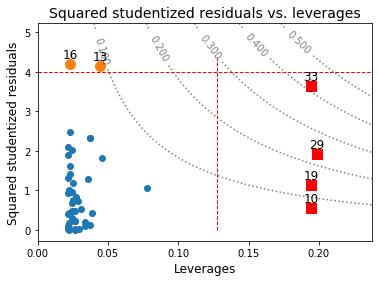

In [73]:
SquaredStudResidLeveragePlot(resultStarR,CookLevels=[0.1,0.2,0.3,0.4,0.5],textdx=-0.005,textdy=0.15)

As we have seen linear transformations do not affect the prediction of the linear regression model, although the regression coefficients might be different due to different scaling of the input variables. If the outcome of the regression model is not affected then why do we have such transformations at all. As we will see in later exercises related to volume 2 and 3 of the book series, the outcome of other machine learnign algorithms will be greatly influenced even when linear transformations are applied.

<img src = "images/AML1-Cover.png" width = 90, align = "left" style="margin:0px 20px">

**Note:** This Jupyter Notebook is accompanying the book: <br><i>"Machine Learning - From Theory to Practice with NumPy and scikit-learn, Volume 1: Generalized Linear Models"</i><br>
by Ferenc Farkas, Ph.D. 

If you find this Notebook useful, please support me by buying the book at [Leanpub](http://leanpub.com/AML1). <br>
Copyright notice: This Jupyter Notebook is made available under the [MIT License](https://opensource.org/licenses/MIT).